<a href="https://colab.research.google.com/github/StergiousAji/DL-Coursework-24_damages/blob/main/DL_Coursework_24_damages.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Damages - Deep Learning Coursework 2024

The aim of this coursework will be for you to design, implement and test a deep learning architecture to detect and identify damage in images. Digitization allows to make historical pictures and art much more widely available to the public. Many such pictures have suffered some form of damage due to time, storage conditions and the fragility of the original medium. For example, the image below (A) shows an example of a digitized parchment that has suffered significant damage over time.

**The aim of this project is for you to design, implement and evaluate a deep learning model to detect and identify damage present in images.**

<table>
<tr>
<td>
<div>
<img src="damage_data/image_path/cljmrkz5n341f07clcujw105j.png" width="500"/>
</div>
</td>
<td>
<div>
<img src="damage_data/annotation_rgb_path/cljmrkz5n341f07clcujw105j.png" width="500"/>
</div>
</td>
</tr>
<td><center>(A) Image</center></td><td><center>(B) damage labels</center></td>
</table>
*(Note that the images will only show once you have downloaded the dataset)*


The image labels in this figure (B) identifies a smatter of peeling paint, a large stained area in the bottom left and a missing part on the top left. Each colour in those images corresponds to a different category of damage, including `fold`, `writing` or `burn marks`. You are provided with a dataset of a variety of damaged images, from Parchment to ceramic or wood painting, and detailed annotations of a range of damages.

You are free to use any architecture you prefer, from what we have seen in class. You can decide to use unsupervised pre-training of only supervised end-to-end training - the approach you choose is your choice.

### Hand-in date: Friday 15th of March before 4:30pm (on Moodle)

### Steps & Hints
* First, look at the data. What are the different type of images (content), what type of material, what type of damage? How different are they? What type of transformations for your data augmentation do you think would be acceptable here?.
* Second, check the provided helper functions for loading the data and separate into training and test set and cross-validation.
* Design a network for the task. What output? What layers? How many? Do you want to use an Autoencoder for unsupervised pre-training?
* Choose a loss function for your network
* Select optimiser and training parameters (batch size, learning rate)
* Optimise your model, and tune hyperparameters (especially learning rate, momentum etc)
* Analyse the results on the test data. How to measure success? Which classes are recognised well, which are not? Is there confusion between some classes? Look at failure cases.
* If time allows, go back to drawing board and try a more complex, or better, model.
* Explain your thought process, justify your choices and discuss the results!

### Submission
* submit ONE zip file on Moodle containing:
  * **your notebook**: use `File -> download .ipynb` to download the notebook file locally from colab.
  * **a PDF file** of your notebook's output as you see it: use `File -> print` to generate a PDF.
* your notebook must clearly contains separate cells for:
  * setting up your model and data loader
  * training your model from data
  * loading your pretrained model from github/gitlab/any other online storage you like!
  * testing your model on test data.
* The training cells must be disabled by a flag, such that when running *run all* on your notebook it does
  * load the data
  * load your model
  * apply the model to the test data
  * analyse and display the results and accuracy
* In addition provide markup cell:
  * containing your student number at the top
  * to describe and motivate your design choices: architecture, pre-processing, training regime
  * to analyse, describe and comment on your results
  * to provide some discussion on what you think are the limitations of your solution and what could be future work

* **Note that you must put your trained model online so that your code can download it.**


### Assessment criteria
* In order to get a pass mark, you will need to demonstrate that you have designed and trained a deep NN to solve the problem, using sensible approach and reasonable efforts to tune hyper-parameters. You have analysed the results. It is NOT necessary to have any level of accuracy (a network that predicts poorly will always yield a pass mark if it is designed, tuned and analysed sensibly).
* In order to get a good mark, you will show good understanding of the approach and provide a working solution.
* in order to get a high mark, you will demonstrate a working approach of gradual improvement between different versions of your solution.
* bonus marks for attempting something original if well motivated - even if it does not yield increased performance.
* bonus marks for getting high performance, and some more points are to grab for getting the best performance in the class.

### Notes
* You are provided code to isolate the test set and cross validation, make sure to keep the separation clean to ensure proper setting of all hyperparameters.
* I recommend to start with small models that can be easier to train to set a baseline performance before attempting more complex one.
* Be mindful of the time!

## Housekeeping

In [3]:
!pip install gdown pytorch_lightning

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

import os
import pandas as pd
import PIL
PIL.Image.MAX_IMAGE_PIXELS = 243748701
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import gdown
import shutil

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
# BATCH-SIZE
batch_size = 16

# Load dataset

We then load the metadata in a dataframe for convenience

In [5]:
!pwd

/content


In [6]:
# Damages dataset mounted to Google Drive so disable download
download = False

if download:
    !gdown 1v8aUId0-tTW3ln3O2BE4XajQeCToOEiS -O damages.zip

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
# set  that to wherever you want to store the data (eg, your Google Drive), choose a persistent location!
root_dir = '/content/drive/MyDrive/'
data_dir = os.path.join(root_dir, "damage_data")
csv_path = os.path.join(data_dir, 'metadata.csv')

try:
    df = pd.read_csv(csv_path)

except:  # if the dataset has not been downloaded yet, do it.
    zip_path = os.path.join(root_dir, 'damages.zip')
    gdown.download(id='1v8aUId0-tTW3ln3O2BE4XajQeCToOEiS', output=zip_path)
    shutil.unpack_archive(zip_path, root_dir)
    df = pd.read_csv(csv_path)

This dataframe has the paths of where the dataset images and annotation labels are stored, plus classification labels.

In [9]:
df

,id,material,content,image_path,annotation_path,annotation_rgb_path
0,cljmrkz5n341f07clcujw105j,Parchment,Artistic depiction,./damage_data/image_path/cljmrkz5n341f07clcujw...,./damage_data/annotation_path/cljmrkz5n341f07c...,./damage_data/annotation_rgb_path/cljmrkz5n341...
1,cljmrkz5n341n07clf1u410ed,Parchment,Artistic depiction,./damage_data/image_path/cljmrkz5n341n07clf1u4...,./damage_data/annotation_path/cljmrkz5n341n07c...,./damage_data/annotation_rgb_path/cljmrkz5n341...
2,cljmrkz5n341r07clhl93dpre,Parchment,Artistic depiction,./damage_data/image_path/cljmrkz5n341r07clhl93...,./damage_data/annotation_path/cljmrkz5n341r07c...,./damage_data/annotation_rgb_path/cljmrkz5n341...
3,cljmrkz5n341v07cl2gfhd6zj,Parchment,Artistic depiction,./damage_data/image_path/cljmrkz5n341v07cl2gfh...,./damage_data/annotation_path/cljmrkz5n341v07c...,./damage_data/annotation_rgb_path/cljmrkz5n341...
4,cljmrkz5n341z07cldbn01un3,Parchment,Artistic depiction,./damage_data/image_path/cljmrkz5n341z07cldbn0...,./damage_data/annotation_path/cljmrkz5n341z07c...,./damage_data/annotation_rgb_path/cljmrkz5n341...
...,...,...,...,...,...,...
390,clnofow7i00n2076ubpfodf4d,Wood,Artistic depiction,./damage_data/image_path/clnofow7i00n2076ubpfo...,./damage_data/annotation_path/clnofow7i00n2076...,./damage_data/annotation_rgb_path/clnofow7i00n...
391,clnrm7fvu092q07840tq9zs03,Wood,Artistic depiction,./damage_data/image_path/clnrm7fvu092q07840tq9...,./damage_data/annotation_path/clnrm7fvu092q078...,./damage_data/annotation_rgb_path/clnrm7fvu092...
392,clnrm7fvu092r0784a6p2m5li,Wood,Artistic depiction,./damage_data/image_path/clnrm7fvu092r0784a6p2...,./damage_data/annotation_path/clnrm7fvu092r078...,./damage_data/annotation_rgb_path/clnrm7fvu092...
393,clnrm7fvu092s0784tgwccewe,Wood,Artistic depiction,./damage_data/image_path/clnrm7fvu092s0784tgwc...,./damage_data/annotation_path/clnrm7fvu092s078...,./damage_data/annotation_rgb_path/clnrm7fvu092...


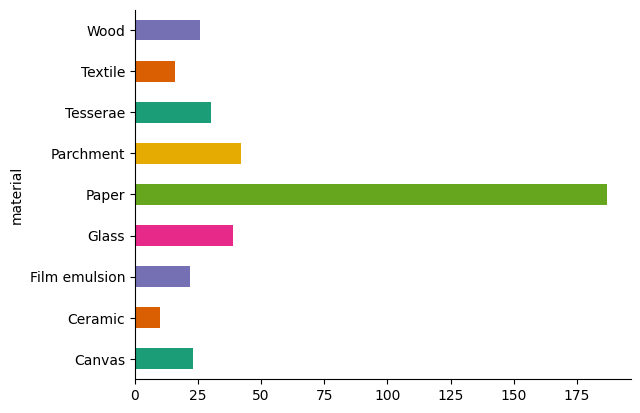

In [10]:
# @title content

from matplotlib import pyplot as plt
import seaborn as sns
df.groupby('material').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

The images in the dataset are categorised in terms of the type of `material`, meaning what was the original picture on, eg, Parchment, Glass or Textile.

In [11]:
df['material'].unique()

array(['Parchment', 'Film emulsion', 'Glass', 'Paper', 'Tesserae',
       'Canvas', 'Textile', 'Ceramic', 'Wood'], dtype=object)

Moreover, images are also categorised in terms on the `content` of the image, meaning what is depicted: eg, Line art, geometric patterns, etc.

In [12]:
df['content'].unique()

array(['Artistic depiction', 'Line art', 'Photographic depiction',
       'Geometric patterns'], dtype=object)

## Labels
Segmentation labels are saved as a PNG image, where each number from 1 to 15 corresponds to a damage class like Peel, Scratch etc; the Background class is set to 255, and the Clean class (no damage) is set to 0. We also provide code to convert these annotation values to RGB colours for nicer visualisation, but for training you should use the original annotations.

In [13]:
name_color_mapping = {
    "Material loss": "#1CE6FF",
    "Peel": "#FF34FF",
    "Dust": "#FF4A46",
    "Scratch": "#008941",
    "Hair": "#006FA6",
    "Dirt": "#A30059",
    "Fold": "#FFA500",
    "Writing": "#7A4900",
    "Cracks": "#0000A6",
    "Staining": "#63FFAC",
    "Stamp": "#004D43",
    "Sticker": "#8FB0FF",
    "Puncture": "#997D87",
    "Background": "#5A0007",
    "Burn marks": "#809693",
    "Lightleak": "#f6ff1b",
}

class_names = [ 'Material loss', 'Peel', 'Dust', 'Scratch',
                'Hair', 'Dirt', 'Fold', 'Writing', 'Cracks', 'Staining', 'Stamp',
                'Sticker', 'Puncture', 'Burn marks', 'Lightleak', 'Background']

class_to_id = {class_name: idx+1 for idx, class_name in enumerate(class_names)}
class_to_id['Background'] = 255  # Set the Background ID to 255

def hex_to_rgb(hex_color: str) -> tuple:
    hex_color = hex_color.lstrip('#')
    return tuple(int(hex_color[i:i+2], 16) for i in (0, 2, 4))

id_to_rgb = {class_to_id[class_name]: hex_to_rgb(color) for class_name, color in name_color_mapping.items()}
id_to_rgb[0] = (0,0,0)

# Create id2label mapping: ID to class name
id2label = {idx: class_name for class_name, idx in class_to_id.items()}

# Create label2id mapping: class name to ID, which is the same as class_to_id
label2id = class_to_id

# Non-damaged pixels
id2label[0] = 'Clean'
label2id['Clean'] = 0

In [14]:
from IPython.display import Markdown

legend='#### Colour labels for each damage type\n'
for damage in class_names:
    legend += '- <span style="color: {color}">{damage}</span>.\n'.format(color=name_color_mapping[damage], damage=damage)
display(Markdown(legend))

#### Colour labels for each damage type
- <span style="color: #1CE6FF">Material loss</span>.
- <span style="color: #FF34FF">Peel</span>.
- <span style="color: #FF4A46">Dust</span>.
- <span style="color: #008941">Scratch</span>.
- <span style="color: #006FA6">Hair</span>.
- <span style="color: #A30059">Dirt</span>.
- <span style="color: #FFA500">Fold</span>.
- <span style="color: #7A4900">Writing</span>.
- <span style="color: #0000A6">Cracks</span>.
- <span style="color: #63FFAC">Staining</span>.
- <span style="color: #004D43">Stamp</span>.
- <span style="color: #8FB0FF">Sticker</span>.
- <span style="color: #997D87">Puncture</span>.
- <span style="color: #809693">Burn marks</span>.
- <span style="color: #f6ff1b">Lightleak</span>.
- <span style="color: #5A0007">Background</span>.


## Create dataset splits

Here is an example of how to split the dataset for Leave-one-out cross validation (LOOCV) based on material.

In [15]:
def create_leave_one_out_splits(df, criterion='material'):
    grouped = df.groupby(criterion)
    content_splits = {name: group for name, group in grouped}
    unique_val = df[criterion].unique()

    # Initialize a dictionary to hold the train and validation sets for each LOOCV iteration
    loocv_splits = {}

    for value in unique_val:
        # Create the validation set
        val_set = content_splits[value]

        # Create the training set
        train_set = pd.concat([content_splits[c] for c in unique_val if c != value])

        # Add these to the loocv_splits dictionary
        loocv_splits[value] = {'train_set': train_set, 'val_set': val_set}

    return loocv_splits

For this coursework, we will want to assess the generalisation of the method, so for that we will keep one type of material (`Canvas`) as test set, and only train on the remaining ones.

In [16]:
# split the dataset according to material type

full_splits = create_leave_one_out_splits(df, 'material')

# use Canvas as test set
test_set = full_splits['Canvas']['val_set']

# use the rest as training set
train_set = full_splits['Canvas']['train_set']

# prepare a leave-one-out cross validation for the training set
loocv_splits = create_leave_one_out_splits(train_set, 'material')

# identify the different type of image content
unique_material = train_set['material'].unique()
print(unique_material)


['Parchment' 'Film emulsion' 'Glass' 'Paper' 'Tesserae' 'Textile'
 'Ceramic' 'Wood']


To help you, here are some helper functions to help crop and process images.

In [17]:
def random_square_crop_params(image, target_size):
    width, height = image.size
    min_edge = min(width, height)

    # Conditionally set the range for random crop size
    lower_bound = min(min_edge, target_size)
    upper_bound = max(min_edge, target_size)

    # Generate crop_size
    crop_size = random.randint(lower_bound, upper_bound)

    # Check and adjust if crop_size is larger than any dimension of the image
    if crop_size > width or crop_size > height:
        crop_size = min(width, height)

    # Generate random coordinates for the top-left corner of the crop
    x = random.randint(0, width - crop_size)
    y = random.randint(0, height - crop_size)

    return (x, y, x + crop_size, y + crop_size)

def apply_crop_and_resize(image, coords, target_size):
    image_crop = image.crop(coords)
    image_crop = image_crop.resize((target_size, target_size), Image.NEAREST)
    return image_crop

We also provide a simple class for holding the dataset

In [18]:
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import random
import numpy as np
from PIL import Image

from torchvision import transforms

class CustomDataset(Dataset):
    def __init__(self, dataframe, target_size, is_train=True):
        self.dataframe = dataframe
        self.target_size = target_size
        self.is_train = is_train

        self.to_tensor = transforms.ToTensor()

        # Define the normalization transform
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                              std=[0.229, 0.224, 0.225])

    def __len__(self):
            return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        image = Image.open(root_dir + row['image_path']).convert('RGB')
        annotation = Image.open(root_dir + row['annotation_path']).convert('L')
        annotation_rgb = Image.open(root_dir + row['annotation_rgb_path']).convert('RGB')
        id = row['id']
        material = row['material']
        content = row['content']

        if self.is_train:
            # Generate random square cropping coordinates
            crop_coords = random_square_crop_params(image, self.target_size)

            # Apply the same cropping and resizing to all
            image = apply_crop_and_resize(image, crop_coords, self.target_size)
            annotation = apply_crop_and_resize(annotation, crop_coords, self.target_size)
            annotation_rgb = apply_crop_and_resize(annotation_rgb, crop_coords, self.target_size)
        else:  # Validation
            # Instead of cropping, downsize the images so that the longest edge is 1024 or less
            max_edge = max(image.size)
            if max_edge > 1024:
                downsample_ratio = 1024 / max_edge
                new_size = tuple([int(dim * downsample_ratio) for dim in image.size])

                image = image.resize(new_size, Image.BILINEAR)
                annotation = annotation.resize(new_size, Image.NEAREST)
                annotation_rgb = annotation_rgb.resize(new_size, Image.BILINEAR)

        # Convert PIL images to PyTorch tensors
        image = self.to_tensor(image)
        annotation = torch.tensor(np.array(annotation), dtype=torch.long)
        annotation_rgb = self.to_tensor(annotation_rgb)

        # Normalize the image
        image = self.normalize(image)

        # Change all values in annotation that are 255 to 16
        annotation[annotation == 255] = 16

        return {
            'image': image,
            'annotation': annotation,
            'annotation_rgb': annotation_rgb,
            'id': id,
            'material': material,
            'content': content
        }

Here we create a DataModule which encapsulates our training and validation DataLoaders; you can also do this manually by only using the Pytorch DataLoader class, lines 24 and 27.

In [19]:
from torch.utils.data import DataLoader

class CustomDataModule(pl.LightningDataModule):
    def __init__(self, loocv_splits, current_material, target_size, batch_size=32, num_workers=4):
        super().__init__()
        self.loocv_splits = loocv_splits
        self.current_material = current_material
        self.target_size = target_size
        self.batch_size = batch_size
        self.num_workers = num_workers

    def prepare_data(self):
        pass

    def setup(self, stage=None):
        # Load current train and validation set based on LOOCV iteration
        train_df = self.loocv_splits[self.current_material]['train_set']
        val_df = self.loocv_splits[self.current_material]['val_set'].sample(frac=1).reset_index(drop=True)

        self.train_dataset = CustomDataset(dataframe=train_df, target_size=self.target_size, is_train=True)
        self.val_dataset = CustomDataset(dataframe=val_df, target_size=self.target_size, is_train=False)

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=self.num_workers)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=1, shuffle=False, num_workers=self.num_workers)

    def test_dataloader(self):
        pass


The following will create a data module for validating on the first content in the list (`Parchment`) and training on all the other types of material (you will want to do that for each fold).

In [20]:
data_module = CustomDataModule(loocv_splits=loocv_splits,
                               current_material=unique_material[0],
                               target_size=512,
                               batch_size=batch_size)

Finally, we can get the train and validation data loaders from the data module.

In [21]:
data_module.setup()
train_loader = data_module.train_dataloader()
val_loader = data_module.val_dataloader()

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


# Dataset visualisation

We need to denormalise the images so we can display them

In [22]:
# Mean and std used for normalization
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

def denormalize(image, mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]):
    img_cpy = image.copy()
    for i in range(3):
        img_cpy[..., i] = img_cpy[..., i] * std[i] + mean[i]
    return img_cpy

## Visualise training samples
Random square crops of the images and correspoding RGB annotations on their own and overlaid onto the image.

In [23]:
visualise = False

if visualise:
    example_batch = next(iter(train_loader))

    example_images = example_batch['image']
    example_annotations = example_batch['annotation']
    example_annotation_rgbs = example_batch['annotation_rgb']

    # Number of examples to visualize
    N = min(4, len(example_images))

    fig, axes = plt.subplots(N, 3, figsize=(15, 5 * N))

    for ax, col in zip(axes[0], ['Image', 'Annotation', 'Overlay']):
        ax.set_title(col, fontsize=24)

    for i in range(N):
        example_image = denormalize(example_images[i].numpy().transpose((1, 2, 0)), mean, std)  # C, H, W -> H, W, C
        example_annotation = Image.fromarray(np.uint8(example_annotations[i].numpy()), 'L')
        example_annotation_rgb = example_annotation_rgbs[i].numpy().transpose((1, 2, 0))  # C, H, W -> H, W, C

        # Create an alpha (transparency) channel where black pixels in annotation_rgb are fully transparent
        alpha_channel = np.all(example_annotation_rgb == [0, 0, 0], axis=-1)
        example_annotation_rgba = np.dstack((example_annotation_rgb, np.where(alpha_channel, 0, 1)))

        axes[i, 0].imshow(example_image)
        axes[i, 0].axis('off')

        # axes[i, 1].imshow(example_annotation, cmap='gray', vmin=0, vmax=255)
        axes[i, 1].imshow(example_annotation_rgb)
        axes[i, 1].axis('off')

        axes[i, 2].imshow(example_image)
        axes[i, 2].imshow(example_annotation_rgba)
        axes[i, 2].axis('off')

    plt.tight_layout()
    plt.show()

Visualising the validation set, which loads the left-out class as whole images.

In [24]:
if visualise:
    val_iter = iter(val_loader)
    example_batches = [next(val_iter) for _ in range(4)]

    # Initialize empty lists to collect different parts of each batch
    example_images = []
    example_annotations = []
    example_annotation_rgbs = []
    example_materials = []
    example_contents = []

    # Populate the lists with the data from the 4 batches
    for batch in example_batches:
        example_images.append(batch['image'].squeeze())
        example_annotations.append(batch['annotation'].squeeze())
        example_annotation_rgbs.append(batch['annotation_rgb'].squeeze())
        example_materials.append(batch['material'][0])
        example_contents.append(batch['content'][0])

    # Number of examples to visualize
    N = min(4, len(example_images))

    fig, axes = plt.subplots(N, 3, figsize=(15, 5 * N))

    for ax, col in zip(axes[0], ['Image', 'Annotation', 'Overlay']):
        ax.set_title(col, fontsize=24)

    for i in range(N):
        example_image = denormalize(example_images[i].numpy().transpose((1, 2, 0)), mean, std)  # C, H, W -> H, W, C
        example_annotation = example_annotations[i].numpy()
        example_annotation_rgb = example_annotation_rgbs[i].numpy().transpose((1, 2, 0))  # C, H, W -> H, W, C
        example_material = example_materials[i]
        example_content = example_contents[i]
        # Create an alpha (transparency) channel where black pixels in annotation_rgb are fully transparent
        alpha_channel = np.all(example_annotation_rgb == [0, 0, 0], axis=-1)
        example_annotation_rgba = np.dstack((example_annotation_rgb, np.where(alpha_channel, 0, 1)))
        axes[i, 0].imshow(example_image)
        axes[i, 0].axis('off')

        axes[i, 1].imshow(example_annotation_rgb)
        axes[i, 1].axis('off')

        axes[i, 2].imshow(example_image)
        axes[i, 2].imshow(example_annotation_rgba)
        axes[i, 2].axis('off')

    plt.tight_layout()
    plt.show()

# Evaluation

For the final evaluation of the model, make sure to test performance on the left out category, `Canvas` to have a fair idea on how well the model generalises.

In [25]:
test_module = CustomDataModule(loocv_splits=full_splits,
                               current_material='Canvas',
                               target_size=512,
                               batch_size=batch_size)

test_module.setup()

test_loader = test_module.val_dataloader()

# Model Creation

In [26]:
class Encoder(nn.Module):
    def __init__(self, latent_size):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1),
            nn.BatchNorm2d(16),
            nn.ReLU()
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, stride=1),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )
        self.maxpool1 = nn.MaxPool2d(kernel_size=3)
        self.conv3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.maxpool2 = nn.MaxPool2d(kernel_size=3)

    def forward(self, x):
        self.input_size = x.shape[2:]
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.maxpool2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.maxpool2(x)

        return x

class Decoder(nn.Module):
    def __init__(self, latent_size):
        super().__init__()
        self.upsample1 = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Upsample((64, 64))
        )
        self.tconv1 = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 32, kernel_size=2, stride=2)
        )
        self.tconv2 = nn.Sequential(
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2)
        )
        self.tconv3 = nn.Sequential(
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, kernel_size=2, stride=2)
        )

    def forward(self, x, target_size):
        x = self.upsample1(x)
        x = self.tconv1(x)
        x = self.tconv2(x)
        x = self.tconv3(x)
        x = F.sigmoid(F.interpolate(x, size=target_size, mode='bilinear', align_corners=True))

        return x

class EncoderDecoder(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, x):
        return self.decoder(self.encoder(x), x.shape[2:])

In [34]:
batch = next(iter(train_loader))

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


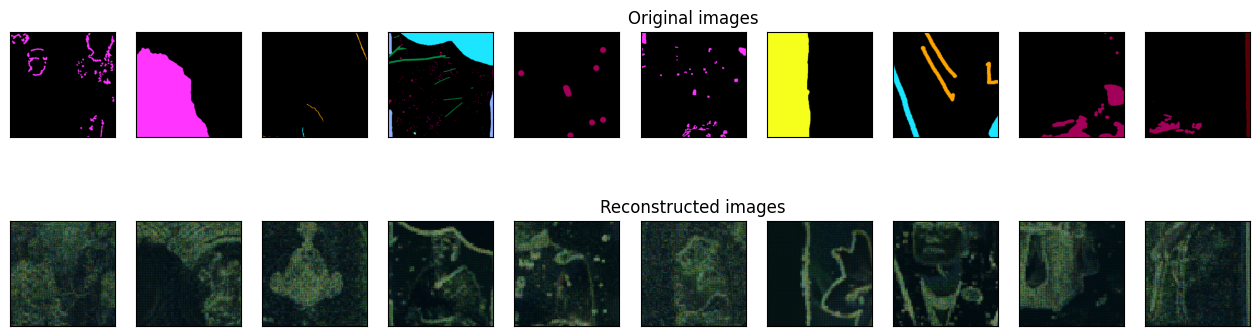

In [78]:
import warnings

# Suppress all Matplotlib warnings
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")

def visualise_outputs(model, dataset=None, batch=None):
    plt.figure(figsize=(16,4.5))

    # batch = next(iter(dataset))
    n = 10
    for i, item in enumerate(batch["image"][:n]):
        with torch.no_grad():
            reconstructed = model(item.unsqueeze(dim=0).to(device))

        ax = plt.subplot(2, n, i+1)
        plt.imshow(np.transpose(batch["annotation_rgb"][i].numpy(), (1, 2, 0)).astype(float))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i == n//2:
          ax.set_title('Original images')

        # plot the reconstruction of the images in the second row
        ax = plt.subplot(2, n, i+n+1)
        plt.imshow(np.transpose(reconstructed.cpu().squeeze().numpy(), (1, 2, 0)).astype(float))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i == n//2:
            ax.set_title('Reconstructed images')

    plt.show()

# visualise_outputs(model, batch=batch)#train_loader)

# Model Loading

In [28]:
def load_model(model_path, model, optimiser):
    epoch = 0
    train_loss_history, val_loss_history = [], []
    try:
        checkpoint = torch.load(model_path)
        model.load_state_dict(checkpoint["model_state_dict"])
        optimiser.load_state_dict(checkpoint["optimiser_state_dict"])
        epoch = checkpoint["epoch"]
        train_loss_history = checkpoint["train_loss_history"]
        val_loss_history = checkpoint["val_loss_history"]
    except Exception as ex:
        print(ex)

    return epoch, train_loss_history, val_loss_history

def load_history(model_path):
    checkpoint = torch.load(model_path)
    return checkpoint["loss_history"]

In [85]:
import os

num_epochs = 15
learning_rate = 0.01
latent_size = 256

encoder = Encoder(latent_size)
decoder = Decoder(latent_size)
model = EncoderDecoder(encoder, decoder).to(device)

# Loss + Optimiser
criterion = nn.CrossEntropyLoss()
optimiser = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=0.001, momentum=0.9)

model_name = f"damage-detector.pt"
# TODO: LOAD FROM GITHUB
if not os.path.exists("model"):
    os.mkdir("model")
cur_epoch, train_loss_history, val_loss_history = load_model(f"model/{model_name}", model, optimiser)

if len(train_loss_history) > 0:
    print(f"{model_name}\n\tEpoch: {cur_epoch}\n\tTrain Loss: {train_loss_history[-1]:.4f}\n\tValidation Loss: {val_loss_history[-1] if len(val_loss_history) > 1 else 0:.4f}")

[Errno 2] No such file or directory: 'model/damage-detector.pt'


# Model Training


Epoch [0/14]:


  0%|          | 0/21 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 21/21 [08:35<00:00, 24.55s/it]


	Average Train Loss: 0.2146


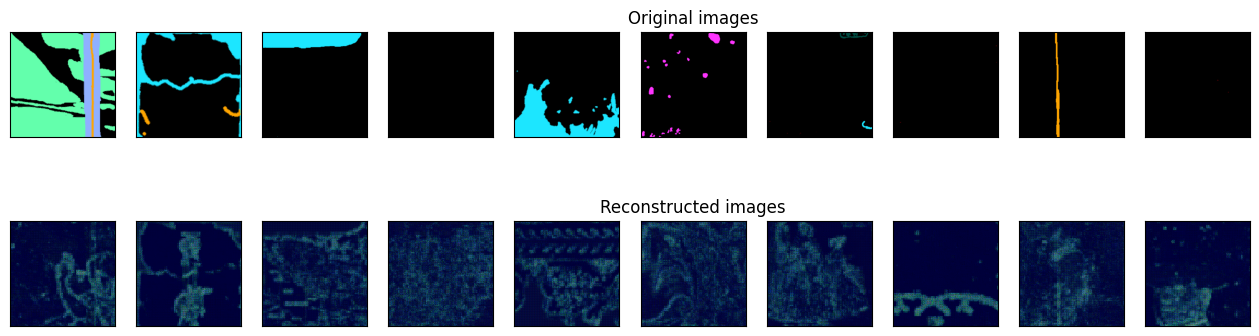

VALIDATION
	Average Train Loss: 0.2146


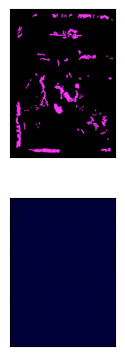


Epoch [1/14]:


100%|██████████| 21/21 [08:33<00:00, 24.45s/it]


	Average Train Loss: 0.1999


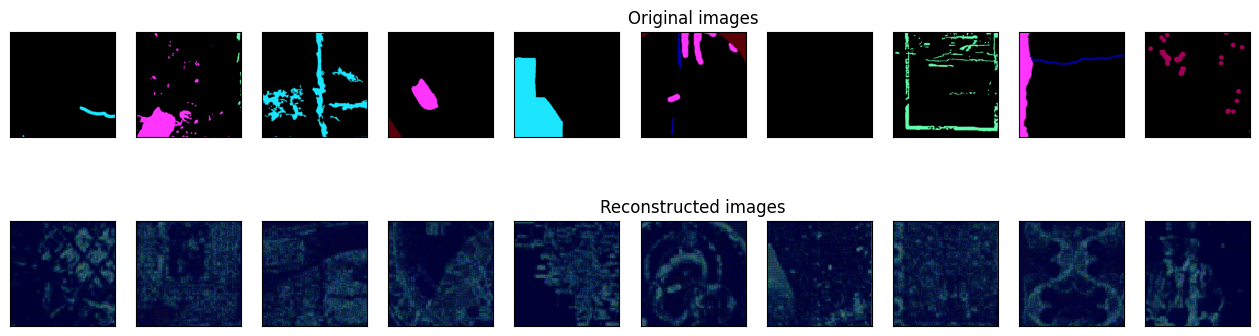

VALIDATION
	Average Train Loss: 0.1999


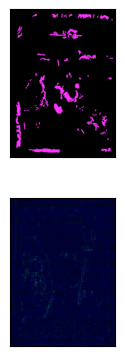


Epoch [2/14]:


100%|██████████| 21/21 [08:34<00:00, 24.51s/it]


	Average Train Loss: 0.2010


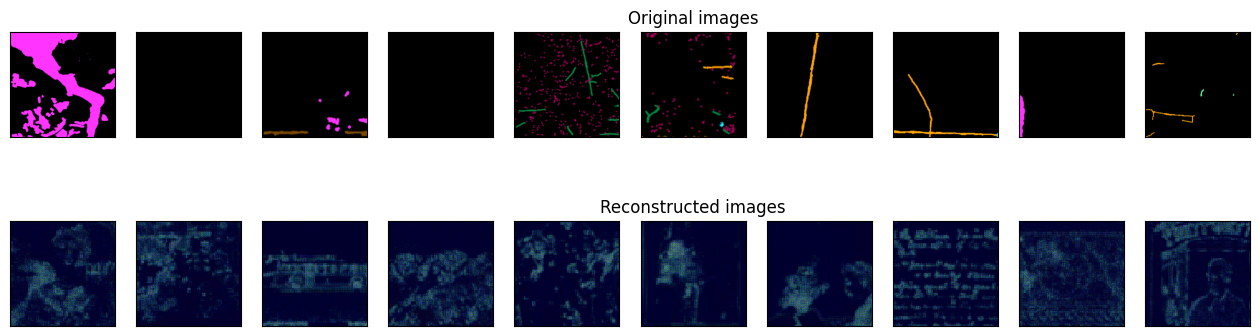

VALIDATION
	Average Train Loss: 0.2010


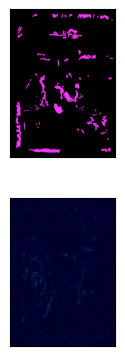


Epoch [3/14]:


100%|██████████| 21/21 [08:40<00:00, 24.78s/it]


	Average Train Loss: 0.1927


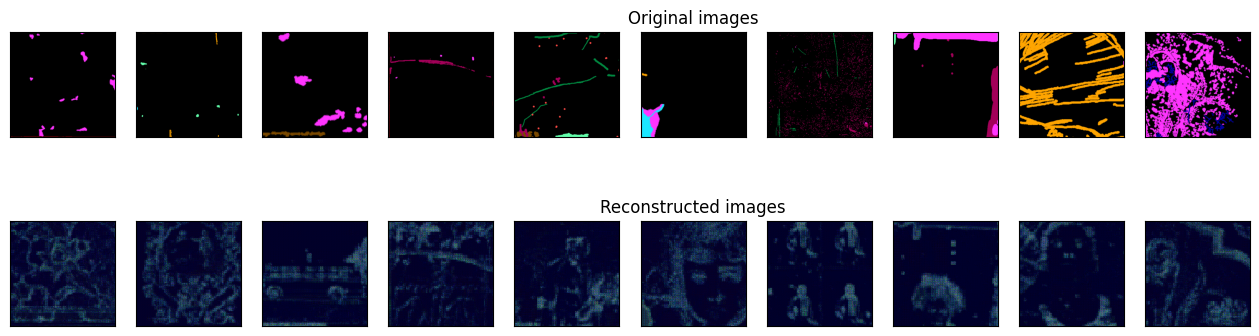

VALIDATION
	Average Train Loss: 0.1927


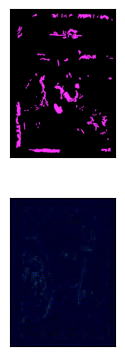


Epoch [4/14]:


100%|██████████| 21/21 [08:33<00:00, 24.47s/it]


	Average Train Loss: 0.2059


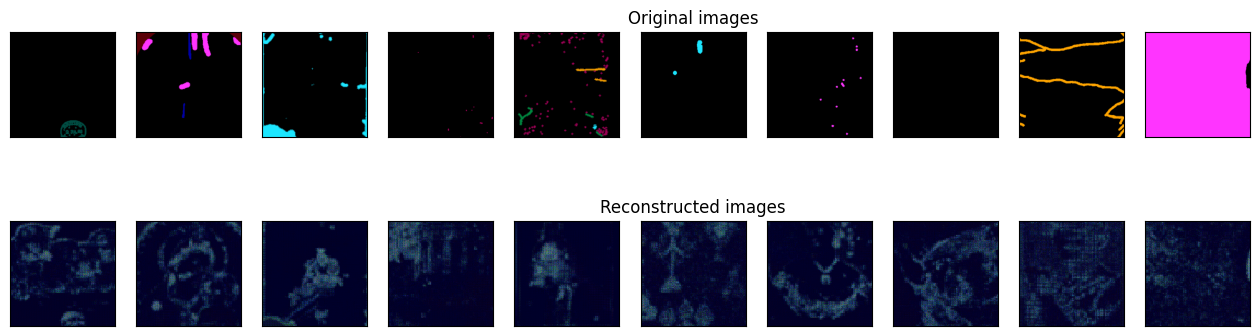

VALIDATION
	Average Train Loss: 0.2059


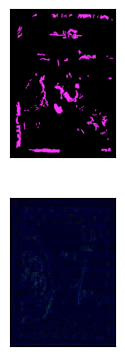


Epoch [5/14]:


100%|██████████| 21/21 [08:36<00:00, 24.58s/it]


	Average Train Loss: 0.2020


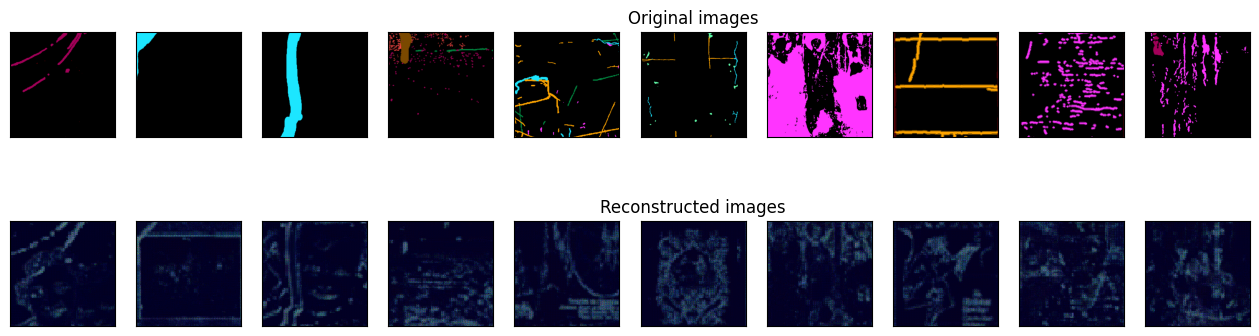

VALIDATION
	Average Train Loss: 0.2020


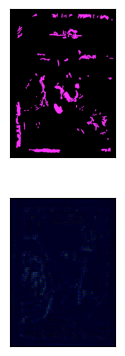


Epoch [6/14]:


100%|██████████| 21/21 [08:33<00:00, 24.46s/it]


	Average Train Loss: 0.1903


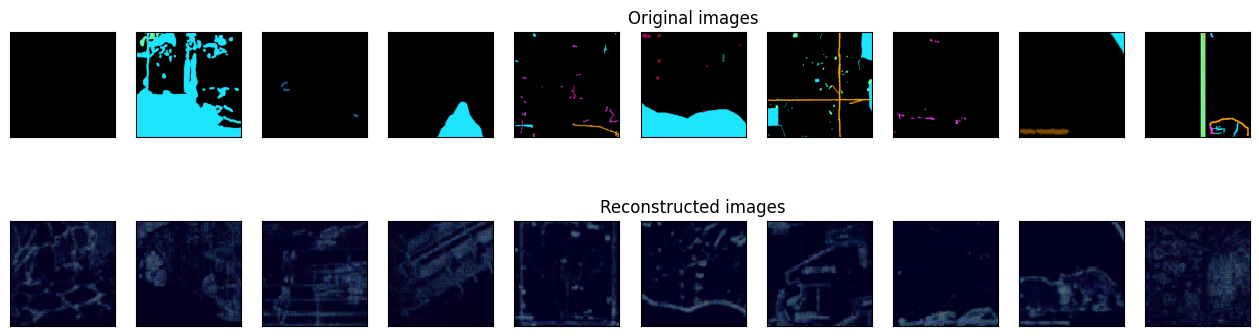

VALIDATION
	Average Train Loss: 0.1903


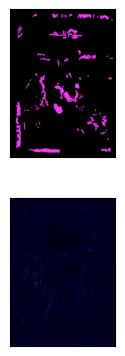


Epoch [7/14]:


100%|██████████| 21/21 [08:21<00:00, 23.88s/it]


	Average Train Loss: 0.2078


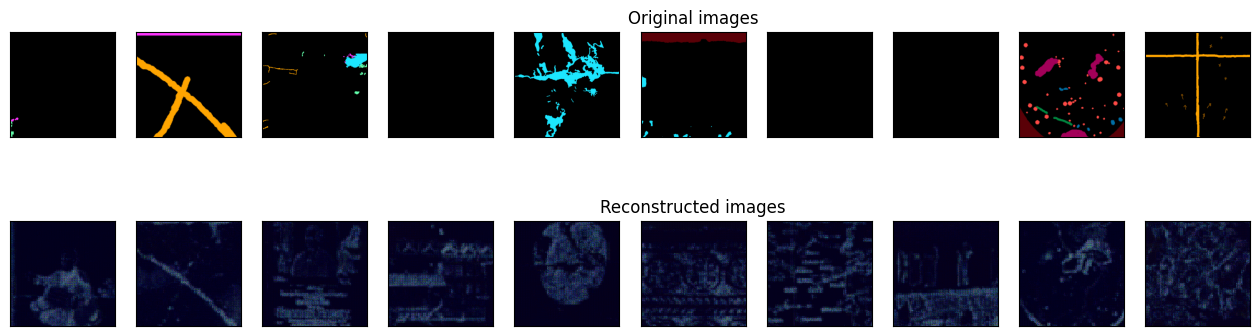

VALIDATION
	Average Train Loss: 0.2078


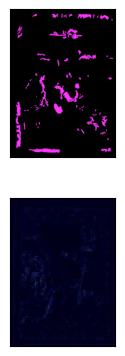


Epoch [8/14]:


 67%|██████▋   | 14/21 [06:14<02:50, 24.37s/it]

In [ ]:
from tqdm import tqdm

for epoch in range(cur_epoch, num_epochs):
    print(f"\nEpoch [{epoch}/{num_epochs-1}]:")
    if os.path.exists(f"models/{model_name}"):
        train_loss_history, val_loss_history = load_history(f"model/{model_name}")

    model.train()
    # Running Loss
    running_loss = 0.
    first_batch = None
    for i, inputs in enumerate(tqdm(train_loader)):
        # Forward Pass
        x = inputs["image"].to(device)
        if i == 0:
            first_batch = inputs
        out = model(x)
        loss = criterion(out, inputs["annotation_rgb"].to(device))

        # Backward Pass and Optimise
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()

        running_loss += loss.item()

        del inputs, x, out
        torch.cuda.empty_cache()

    avg_train_loss = running_loss/len(train_loader)
    print(f"\tAverage Train Loss: {avg_train_loss:.4f}")
    # print(first_batch)
    visualise_outputs(model, batch=first_batch)

    torch.save({"epoch": epoch+1,
                "model_state_dict": model.state_dict(),
                "optimiser_state_dict": optimiser.state_dict(),
                "train_loss_history": train_loss_history + [avg_train_loss],
                "val_loss_history": val_loss_history},
                f"model/{model_name}")

    # Validation
    print("VALIDATION")
    model.eval()
    with torch.no_grad():
        running_val_loss = 0.
        first_batch = None
        for i, inputs in enumerate(val_loader):
            x = inputs["image"].to(device)
            if i == 0:
                first_batch = inputs
            out = model(x)
            loss = criterion(out, inputs["annotation_rgb"].to(device))
            running_val_loss += loss.item()

            del inputs, x, out

        avg_val_loss = running_val_loss/len(val_loader)
        print(f"\tAverage Train Loss: {avg_train_loss:.4f}")
        visualise_outputs(model, batch=first_batch)

    model_checkpoint = torch.load(f"model/{model_name}")
    model_checkpoint["val_loss_history"].append(avg_val_loss)
    torch.save(model_checkpoint, f"model/{model_name}")